In [49]:
from tools.DataLoader import DataLoader
from tools.ULModelEvaluator import ULModelEvaluator
from tools.ULModelTrainer import ULModelTrainer
from tools.AddCountFeatureTransformer import AddCountFeatureTransformer
from tools.EDA import EDA
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector

In [50]:
# Step 1: Load Data using DataLoader
data_loader = DataLoader(
    request_type="local", path="db/mod_05_topic_10_various_data.pkl"
)
df_dict = data_loader.load_data()
df = df_dict["concrete"]

In [51]:
# Step 2: Perform EDA using the EDA class
eda = EDA(df)

# Perform EDA using the EDA class
eda = EDA(df)
eda.perform_full_eda()

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1030 non-null   float64
 1   BlastFurnaceSlag     1030 non-null   float64
 2   FlyAsh               1030 non-null   float64
 3   Water                1030 non-null   float64
 4   Superplasticizer     1030 non-null   float64
 5   CoarseAggregate      1030 non-null   float64
 6   FineAggregate        1030 non-null   float64
 7   Age                  1030 non-null   int64  
 8   CompressiveStrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


None

,Column,Has_Nulls,Dtype
Cement,Cement,False,float64
BlastFurnaceSlag,BlastFurnaceSlag,False,float64
FlyAsh,FlyAsh,False,float64
Water,Water,False,float64
Superplasticizer,Superplasticizer,False,float64
CoarseAggregate,CoarseAggregate,False,float64
FineAggregate,FineAggregate,False,float64
Age,Age,False,int64
CompressiveStrength,CompressiveStrength,False,float64



Dataset Shape:

(1030, 9)

Descriptive Statistics:



,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
BlastFurnaceSlag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
FlyAsh,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
Water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
Superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
CoarseAggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
FineAggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
Age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
CompressiveStrength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6



Missing Values:



Cement                 0
BlastFurnaceSlag       0
FlyAsh                 0
Water                  0
Superplasticizer       0
CoarseAggregate        0
FineAggregate          0
Age                    0
CompressiveStrength    0
dtype: int64


Sample Data:



,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [52]:
# Feature Engineering Pipeline
feature_engineering_pipeline = Pipeline(
    steps=[
        (
            "add_count",
            AddCountFeatureTransformer(
                material_columns=[
                    "Cement",
                    "BlastFurnaceSlag",
                    "FlyAsh",
                    "Water",
                    "Superplasticizer",
                    "CoarseAggregate",
                    "FineAggregate",
                ],
                new_feature_name="Count",
            ),
        ),
        # ("passthrough", "passthrough"),
    ]
)

In [53]:
# Define categorical transformer
cat_transformer = Pipeline(
    steps=[
        ("passthrough", "passthrough"),
    ]
)

# Define numerical transformer
num_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
        # ("pasathrough", "passthrough")
    ]
)

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, make_column_selector(dtype_include=np.number)),
        (
            "cat",
            cat_transformer,
            make_column_selector(dtype_include=[object, "category"]),
        ),
    ],
    n_jobs=-1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [54]:
# Create full preprocessing pipeline with feature engineering and preprocessor
full_preprocessing_pipeline = Pipeline(
    steps=[
        ("feature_engineering", feature_engineering_pipeline),
        ("preprocessing", preprocessor),
    ]
)

In [55]:
# Create full pipeline with preprocessing and model
full_pipeline_kmeans = Pipeline(
    steps=[
        ("full_preprocessing", full_preprocessing_pipeline),
        ("model", KMeans()),
    ]
)

In [56]:
# Define the parameter grid
param_grids = {
    "kmeans": {
        "model__n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "model__random_state": [40],
    }
}

In [57]:
# Combine pipelines into a dictionary
model_pipelines = {"kmeans": full_pipeline_kmeans}

In [58]:
# Create an instance of ClusterPipeline and train models
model_trainer = ULModelTrainer()
model_trainer.train(df, model_pipelines, param_grids, scoring="silhouette_score")

In [59]:
cluster_labels = model_trainer.predict(df)

In [60]:
evaluator = ULModelEvaluator()

In [61]:
evaluator.visualize_pipeline(model_trainer.best_model)

Pipeline(steps=[('full_preprocessing',
                 Pipeline(steps=[('feature_engineering',
                                  Pipeline(steps=[('add_count',
                                                   AddCountFeatureTransformer(material_columns=['Cement',
                                                                                                'BlastFurnaceSlag',
                                                                                                'FlyAsh',
                                                                                                'Water',
                                                                                                'Superplasticizer',
                                                                                                'CoarseAggregate',
                                                                                                'FineAggregate']))])),
                                 ('preprocessing',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x77d389c9c170>),
                                                                  ('cat',
                                                                   Pipeline(steps=[('passthrough',
                                                                                    'passthrough')]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x77d389c9da30>)],
                                                    verbose_feature_names_out=False))])),
                ('model', KMeans(n_clusters=6, random_state=40))])

In [62]:
df_fe = feature_engineering_pipeline.fit_transform(df)
df_transformed = full_preprocessing_pipeline.fit_transform(df)

In [63]:
evaluator.display_results(
    df_transformed,
    cluster_labels,
    model_trainer.best_model,
    model_trainer.best_params,
    model_trainer.best_score,
    help_text=True,
)

Evaluation Metrics for Best Model:


,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,Pipeline,0.271587,1.316547,258.705311



Best Parameters for the Model:


,model__n_clusters,model__random_state
0,6,40



Metric Explanations:
Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters.
  - Range: [-1, 1], higher is better.
  - Higher values indicate better-defined clusters.
Davies-Bouldin Index: Measures the average similarity ratio of each cluster with its most similar cluster.
  - Range: [0, ∞), lower is better.
  - Lower values indicate better clustering.
Calinski-Harabasz Index: Ratio of the sum of between-cluster dispersion to within-cluster dispersion.
  - Range: [0, ∞), higher is better.
  - Higher values indicate better-defined clusters.


In [64]:
# Generate cluster report
cluster_report = evaluator.generate_cluster_report(df_fe, cluster_labels)
display(cluster_report)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength,Count,ObjectCount
Cluster,,,,,,,,,,,
0,213.70,0.00,121.6,167.0,8.1,1014.3,793.50,28.0,33.360,6.0,285
1,339.00,0.00,0.0,192.0,0.0,1013.2,784.00,28.0,26.060,4.0,197
2,386.00,118.00,0.0,162.0,11.6,938.0,782.00,28.0,56.615,6.0,188
3,183.90,185.30,0.0,192.0,0.0,965.4,749.10,28.0,26.590,5.0,166
4,252.05,110.75,123.0,193.3,8.5,877.6,749.15,28.0,32.325,7.0,138
5,340.50,38.00,0.0,228.0,0.0,932.0,670.00,270.0,43.355,5.0,56


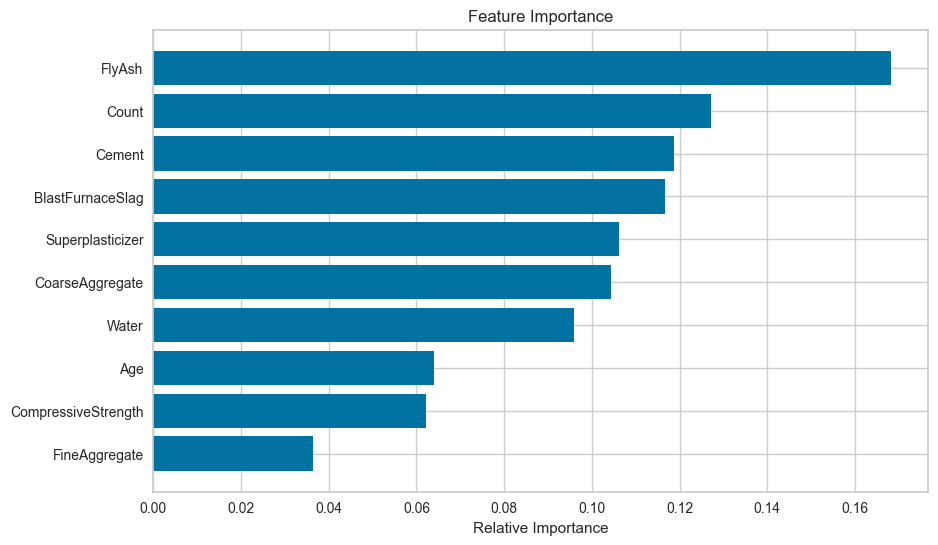

In [68]:
# Evaluate feature importance
evaluator.feature_importance(df_transformed, cluster_labels, df_fe)